In [ ]:
# 1a) Load the wave files using librosa with original sampling rate

import matplotlib.pyplot as plt
import numpy as np
import librosa
import sounddevice as sd

# Load both signals without changing their sampling rate
v_signal1, sampling_rate1 = librosa.load("speech1.wav", sr=None)
v_signal2, sampling_rate2 = librosa.load("speech2.wav", sr=None)

# Print the sampling rates
print(f"Sampling Rate 1: {sampling_rate1} Hz")
print(f"Sampling Rate 2: {sampling_rate2} Hz")



✅ Answer:
Sampling Rate 1: 16000 Hz
Sampling Rate 2: 16000 Hz

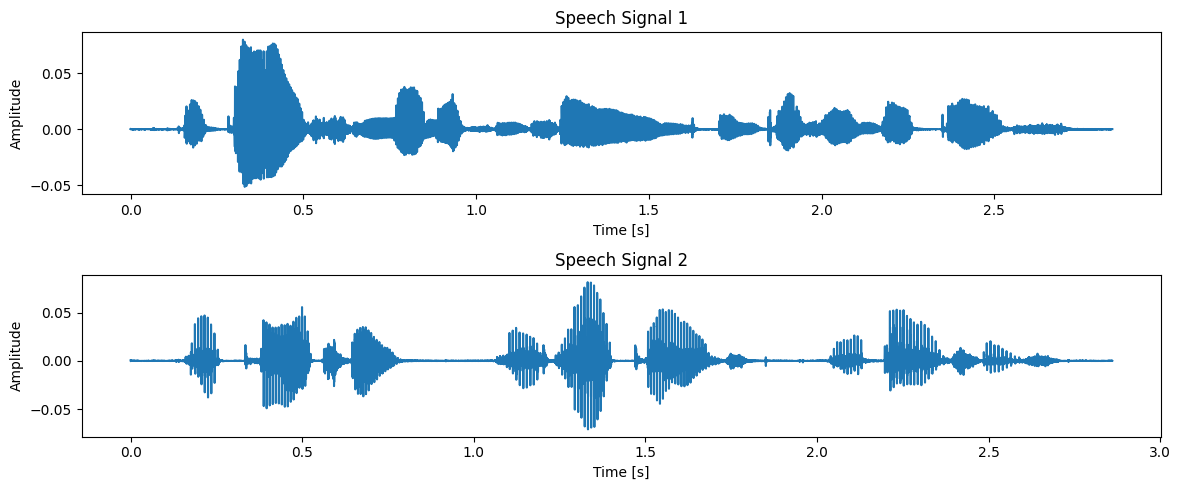

In [19]:
# 1b) Plot the signal as a function of time

# Create time vectors
v_time1 = np.arange(len(v_signal1)) / sampling_rate1
v_time2 = np.arange(len(v_signal2)) / sampling_rate2

# Plot both waveforms
plt.figure(figsize=(12, 5))

plt.subplot(2, 1, 1)
plt.plot(v_time1, v_signal1)
plt.title("Speech Signal 1")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
plt.plot(v_time2, v_signal2)
plt.title("Speech Signal 2")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


✅ Answer: 
Voiced: Periodic structure with high amplitude
Unvoiced: Noise-like and less regular, lower amplitude
Silence: Near-zero flat line



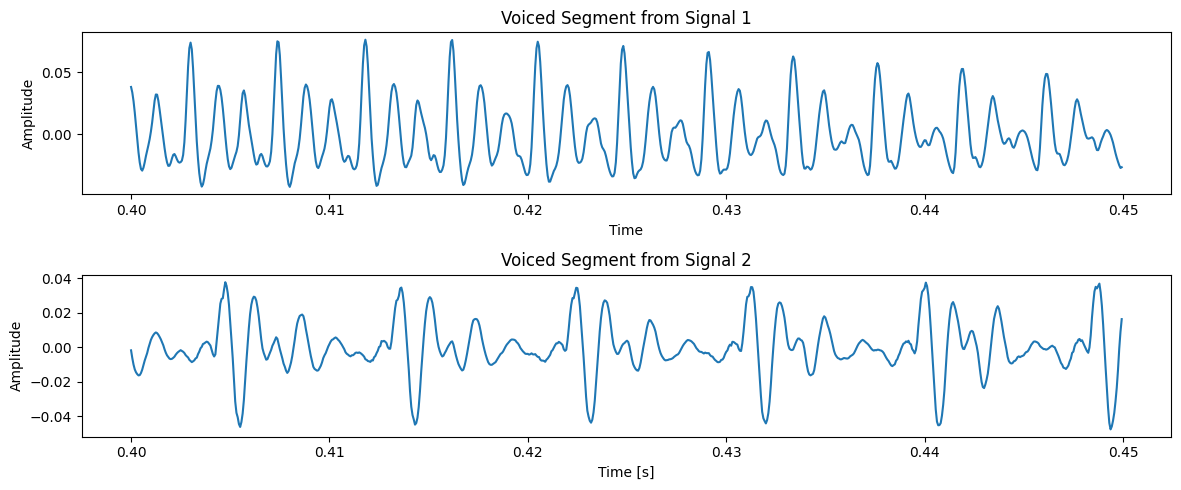

In [20]:
# 1c) Select voiced segments manually based on waveform inspection

# For signal 1, select around 1.0–1.05s
start1 = int(0.40 * sampling_rate1)
end1   = int(0.45 * sampling_rate1)
voiced_segment1 = v_signal1[start1:end1]
t_voiced1 = np.arange(start1, end1) / sampling_rate1

# For signal 2, select around 1.2–1.25s
start2 = int(0.40 * sampling_rate2)
end2   = int(0.45 * sampling_rate2)
voiced_segment2 = v_signal2[start2:end2]
t_voiced2 = np.arange(start2, end2) / sampling_rate2

# Plot both segments for visual inspection
plt.figure(figsize=(12, 5))

plt.subplot(2, 1, 1)
plt.plot(t_voiced1, voiced_segment1)
plt.title("Voiced Segment from Signal 1")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
plt.plot(t_voiced2, voiced_segment2)
plt.title("Voiced Segment from Signal 2")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


✅ Answer:
By counting periodic cycles in the plot:
Signal 1 ≈ ~9 pitch cycles in 50 ms = 180 Hz
Signal 2 ≈ ~5 pitch cycles in 50 ms = 100 Hz
Conclusion:
Signal 1 → Female speaker
Signal 2 → Male speaker

In [21]:
print("🔊 Playing Speech Signal 1 (Female voice)...")
sd.play(v_signal1, samplerate=sampling_rate1)
sd.wait()

print("🔊 Playing Speech Signal 2 (Male voice)...")
sd.play(v_signal2, samplerate=sampling_rate2)
sd.wait()


🔊 Playing Speech Signal 1 (Female voice)...
🔊 Playing Speech Signal 2 (Male voice)...


In [22]:
# 2) Windowing Function to split signal into overlapping frames
def my_windowing(v_signal: np.ndarray, sampling_rate: int, frame_length_ms: int, frame_shift_ms: int):
    """
    Splits the signal into overlapping frames.

    Parameters:
        v_signal         : Input signal (1D numpy array)
        sampling_rate    : Sampling rate in Hz
        frame_length_ms  : Frame length in milliseconds
        frame_shift_ms   : Frame shift (hop size) in milliseconds

    Returns:
        m_frames         : 2D array with one frame per row
        v_time_frame     : Time instants (center) of each frame
    """
    frame_length = int((frame_length_ms / 1000) * sampling_rate)
    frame_shift = int((frame_shift_ms / 1000) * sampling_rate)
    
    # Calculate the number of frames that fit into the signal
    num_frames = 1 + (len(v_signal) - frame_length) // frame_shift

    # Initialize output arrays
    m_frames = np.zeros((num_frames, frame_length))
    v_time_frame = np.zeros(num_frames)

    for i in range(num_frames):
        start = i * frame_shift
        end = start + frame_length
        m_frames[i] = v_signal[start:end]
        v_time_frame[i] = (start + frame_length // 2) / sampling_rate

    return m_frames, v_time_frame


✅ Answer:
In how many frames can the input signal be split?

You can compute the number of frames using this formula: num_frames = 1 + [(N-L)/S], where:
N = total number of samples in the signal
L = frame length (in samples)
S = frame shift (in samples)





In [23]:
# (((3a))) Split the signal into 32 ms frames with 16 ms shift

# Apply to both speech signals with 32 ms frames and 16 ms shift
m_frames1, v_time_frame1 = my_windowing(v_signal1, sampling_rate1, frame_length_ms=32, frame_shift_ms=16)
m_frames2, v_time_frame2 = my_windowing(v_signal2, sampling_rate2, frame_length_ms=32, frame_shift_ms=16)

print(f"Number of frames for signal 1: {len(m_frames1)}")
print(f"Number of frames for signal 2: {len(m_frames2)}")


Number of frames for signal 1: 176
Number of frames for signal 2: 177


✅ Answer:

Number of frames for signal 1: 176
Number of frames for signal 2: 177

In [24]:
# 3b) Compute the ACF using np.convolve / 3c) Remove the lower half (negative lags)

def compute_acf_matrix(m_frames: np.ndarray):
    """
    Compute the autocorrelation function (ACF) for each frame.
    Returns only the positive-lag part of the ACF (lags >= 0).

    Parameters:
        m_frames : 2D array of frames (each row is a frame)

    Returns:
        acf_matrix : 2D array with ACFs (lags >= 0)
    """
    num_frames, frame_len = m_frames.shape
    acf_matrix = np.zeros((num_frames, frame_len))

    for i in range(num_frames):
        frame = m_frames[i]
        # Full ACF via convolution of frame with time-reversed version
        acf_full = np.convolve(frame, frame[::-1], mode='full')
        # Keep only lags >= 0 (centered at frame_len - 1)
        acf_matrix[i] = acf_full[frame_len - 1:]

    return acf_matrix

acf_matrix1 = compute_acf_matrix(m_frames1)
acf_matrix2 = compute_acf_matrix(m_frames2)


In [25]:
# 3d) Estimate f0 using ACF peak in valid lag range

def estimate_f0_from_acf(acf_matrix: np.ndarray, sampling_rate: int, fmin=80, fmax=400):
    """
    Estimate the fundamental frequency from ACF for each frame.

    Parameters:
        acf_matrix   : 2D array of ACFs (positive lags only)
        sampling_rate: Sampling rate in Hz
        fmin         : Minimum allowed frequency (Hz)
        fmax         : Maximum allowed frequency (Hz)

    Returns:
        v_f0         : 1D array of estimated fundamental frequencies per frame
    """
    num_frames, frame_len = acf_matrix.shape
    v_f0 = np.zeros(num_frames)

    # Convert frequency range to lag range
    min_lag = sampling_rate // fmax
    max_lag = sampling_rate // fmin

    for i in range(num_frames):
        acf = acf_matrix[i]
        search_region = acf[min_lag:max_lag]
        if len(search_region) > 0:
            peak_index = np.argmax(search_region) + min_lag
            v_f0[i] = sampling_rate / peak_index
        else:
            v_f0[i] = 0.0  # fallback if no peak found

    return v_f0

v_f0_1 = estimate_f0_from_acf(acf_matrix1, sampling_rate1)
v_f0_2 = estimate_f0_from_acf(acf_matrix2, sampling_rate2)


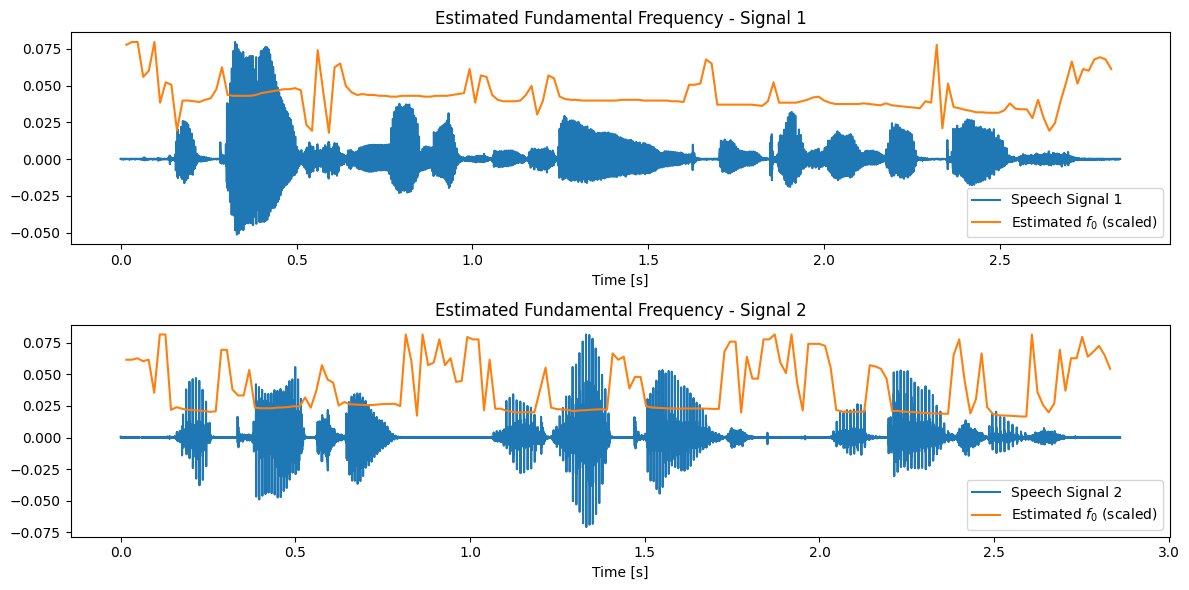

In [26]:
# 3e) Plot signal and estimated f0

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(v_time1, v_signal1, label="Speech Signal 1")
plt.plot(v_time_frame1, v_f0_1 / max(v_f0_1) * max(v_signal1), label="Estimated $f_0$ (scaled)")
plt.title("Estimated Fundamental Frequency - Signal 1")
plt.xlabel("Time [s]")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(v_time2, v_signal2, label="Speech Signal 2")
plt.plot(v_time_frame2, v_f0_2 / max(v_f0_2) * max(v_signal2), label="Estimated $f_0$ (scaled)")
plt.title("Estimated Fundamental Frequency - Signal 2")
plt.xlabel("Time [s]")
plt.legend()

plt.tight_layout()
plt.show()


✅ Answer – Interpretation
The estimator gives good results in voiced regions (where the waveform is periodic).
In unvoiced/silent segments, the ACF is flat → the estimated f0 drops or becomes unstable.
The result matches well with visual estimates from Exercise 1
Signal 1 → ~180 Hz → Female voice ✅
Signal 2 → ~100 Hz → Male voice ✅


